In [28]:
# !unzip SocialTalk2023.zip

In [1]:
import pandas as pd
import numpy as np
import os
import umap
import json

import networkx as nx
from gensim.models import KeyedVectors
from nodevectors import Node2Vec, GGVec

import plotly.express as px

In [11]:
# Shape (2931112, 23)
users  = pd.read_csv('../SocialTalk 2023/accounts.csv', on_bad_lines='skip', low_memory=False) #We are encoutering some bad lines creating some error so we skip over them
users = users[:20000]
users['label'] = users['Id'].apply(lambda x: f'Account:{x}') #adding label here
users['Social network'] = users['Social network'].replace(['None'],np.nan) # replacing 'None' in Social network with np.nan

In [12]:
users.head()

,Id,Social network,Username,Name,Country id,City id,Birthdate,Gender,Followers,Following,...,Estimated impressions,Avg. posts per week,Avg. posts per month,Avg. likes per post,Avg. engagement per post,Avg. comments per post,Avg. views per video,Relevant tags,Audience credibility,label
0,151,Instagram,tigasdude,Tiago Oliveira,374,760.0,09-07-1982,Male,154,250,...,0,1,1,0.0,0.0,0.0,0.0,0.92233,NaN,Account:151
1,152,Instagram,jasonderulo,Jason Derulo,401,39.0,NaN,Male,22625181,10,...,1274777,9,33,434816.0,436917.0,2100.0,1062313.0,"slidin,takethestage,mooski,dancin,gaspedal,mov...",0.67460,Account:152
2,153,Instagram,cristiano,Cristiano Ronaldo,360,306.0,05-02-1985,Male,550332150,552,...,21930580,4,14,9809591.0,9929137.0,119545.0,18275482.0,"nikefc,nikeathlete,adiddas,nikefootball,nikeso...",0.75930,Account:153
3,154,Instagram,ronaldinho,Ronaldo de Assis Moreira,201,18.0,NaN,Male,71552085,523,...,1780110,4,14,588709.0,591441.0,2731.0,1435571.0,"allezparis,psg,robertocarlos,copadomundo,champ...",0.79090,Account:154
4,155,Instagram,addisonraee,Addison Rae,401,NaN,NaN,Female,39861444,235,...,4484413,2,6,906753.0,908520.0,1767.0,0.0,"aejeans,aexme,americaneaglejeans,americaneagle...",0.84937,Account:155


In [13]:
users[users['Social network'] == 'Youtube']['Followers'].value_counts()

0        23
1         7
4         3
52        3
20        3
         ..
14000     1
1860      1
227       1
90        1
3         1
Name: Followers, Length: 166, dtype: int64

In [4]:
#Country-ID mapping
city_ids = pd.read_csv('../SocialTalk 2023/cities.csv', low_memory=False) #Shape (7087, 2)
country_ids = pd.read_csv('../SocialTalk 2023/countries.csv', low_memory=False) #[183,2]

In [5]:
country_ids

,Id,Name
0,374,Spain
1,401,United States
2,201,Brazil
3,267,India
4,400,United Kingdom
...,...,...
182,220,Comoros
183,304,Mauritania
184,200,Botswana
185,393,Turkmenistan


In [6]:
# MAP: account ids to country,city,gender
clean_df = users[['Id','Country id','City id','Gender','Social network','Followers',"Estimated reach","Avg. views per video"]]

In [7]:
clean_df['Id'] = clean_df['Id'].apply(lambda x: f'Account:{x}')
clean_df = clean_df.rename(columns={'City id': 'City','Country id': 'Country','Social network':'Social_network',
                                    "Avg. views per video":"Avg._views_per_video",
                                    "Estimated reach":"Estimated_reach"}).set_index('Id')

clean_df['City'] = clean_df['City'].map(city_ids.set_index('Id')['Name'].to_dict())
clean_df['City'] = clean_df['City'].str.replace(" ","_") #Replace white space by "_"
clean_df['Country'] = clean_df['Country'].astype(float).map(country_ids.set_index('Id')['Name'].to_dict())
clean_df['Country'] = clean_df['Country'].str.replace(" ","_")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
clean_df = clean_df[(clean_df["Followers"] != 'Female') & (clean_df["Followers"] != 'Male')] #There is [Male, Female] as values for Followers column

In [9]:
#TODO: BIN numerical nodes (current code not working for whole data)

clean_df["Followers"]=clean_df["Followers"].astype('float64')
for i in clean_df.columns[-3:]:
    if i !='Avg._views_per_video':
        clean_df[i] = pd.qcut(clean_df[i],q=3,labels=["low","average","high"],duplicates='drop')
    else:
        clean_df[i] = pd.qcut(clean_df[i],q=4,labels=["low","average","high"],duplicates='drop')
        


In [10]:
'''
#NO brand-accound, interest-brand
'''
brand_ids = pd.read_csv('../SocialTalk 2023/brands.csv', low_memory=False) # Shape (3792, 2)
account_brands = pd.read_csv('../SocialTalk 2023/accounts-brands.csv', low_memory=False)
interest_ids = pd.read_csv('../SocialTalk 2023/interests.csv', low_memory=False) # Shape (60, 2)
account_interests = pd.read_csv('../SocialTalk 2023/accounts-interests.csv', low_memory=False)

In [11]:
brand_ids['label'] = 'Brand:' + brand_ids['Name'].astype(str)
account_brands['Account Id'] = 'Account:' + account_brands['Account Id'].astype(str)
account_brands['Brand Id'] = account_brands['Brand Id'].map(brand_ids.set_index('Id')['label'].to_dict())

interest_ids['label'] = 'Interest:' + interest_ids['Name'].astype(str)
account_interests['Account Id'] = 'Account:' + account_interests['Account Id'].astype(str)
account_interests['Interest Id'] = account_interests['Interest Id'].map(interest_ids.set_index('Id')['label'].to_dict())

In [12]:
'''
Lets make edge pairs in the given format
(account, f'{column}:{value}') for each column with non-nan values

'''
edges = []
for column in clean_df.columns:
    series_tuples = [
        (account, f'{column}:{value}') for account, value in clean_df[clean_df[column].notna()][column].items()
        ]
    edges.extend(series_tuples)

In [56]:
edges += [i for i in account_brands.set_index('Account Id')['Brand Id'].items()]
edges += [i for i in account_interests.set_index('Account Id')['Interest Id'].items()]

In [13]:
location_hierarchy = [
    (f'Country:{country}', f'City:{city}') for country, city in clean_df[['Country', 'City']].dropna().drop_duplicates(subset=['Country', 'City'], keep='last').values
]
edges.extend(location_hierarchy)

In [14]:
len(edges)

125755

In [16]:
temp = pd.DataFrame(edges, columns=['source', 'target'])
temp.to_csv(f'edge_list_{len(edges)}.csv',index=False)

In [17]:
G = nx.from_pandas_edgelist(temp)

In [ ]:
%%timeit 
g2v = Node2Vec(verbose=True)
n2v_embeddings = g2v.fit(G)
g2v.save_vectors("wheel_model.bin")

In [7]:
with open('user_lookup.json', 'r') as f:
    user_lookup = json.load(f)

In [46]:
def get_visualization_df(embeddings, user_lookup):
    visuals = pd.DataFrame(embeddings, index=words, columns=['x', 'y', 'z'])
    visuals['size'] = 0.01
    visuals['node_type'] = [i.split(':')[0] if not (i.split(':')[1] == 'True') else 'Age' for i in visuals.index.tolist()]
    visuals = visuals.reset_index()

    account_nodes = visuals[visuals['node_type'] == 'Account']
    account_ids = account_nodes['index'].apply(lambda x: x.split(':')[1]).astype(str)
    account_metadata = pd.DataFrame(account_ids.map(user_lookup).values.tolist(), index=account_ids)
    account_metadata.index = [f'Account:{i}' for i in account_metadata.index]
    account_metadata = account_metadata.reset_index()

    final = visuals.merge(account_metadata, on='index', how='left')
    final['Name'] = final['Name'].fillna('')
    final['Followers'] = final['Followers'].fillna(0)
    final['Estimated reach'] = final['Estimated reach'].fillna(0)

    return final

In [48]:
model = KeyedVectors.load_word2vec_format("a.bin")
words = list(model.wv.vocab)
g2v_embeds = pd.DataFrame([model.wv[i] for i in words], index=words)

reducer = umap.UMAP(n_components=3, min_dist=0.25, n_neighbors=100)
embeddings = reducer.fit_transform(g2v_embeds)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
visuals = pd.DataFrame(embeddings, index=words, columns=['x', 'y', 'z'])
    visuals['size'] = 0.01
    visuals['node_type'] = [i.split(':')[0] if not (i.split(':')[1] == 'True') else 'Age' for i in visuals.index.tolist()]

In [ ]:
final = get_visualization_df(embeddings, user_lookup)
final.to_csv('final_app_input_df_1.csv', index=None)

In [56]:
model

In [34]:
temp['source']

0           Account:151
1           Account:152
2           Account:153
3           Account:154
4           Account:157
              ...      
105293    Account:20231
105294    Account:20232
105295    Account:20233
105296    Account:20234
105297    Account:20235
Name: source, Length: 105298, dtype: object

# GGvec

In [167]:
import csrgraph as cg
import nodevectors

G = cg.read_edgelist("edge_list_125755.csv", directed=False, sep=',')
ggvec_model = nodevectors.GGVec(verbose=True,n_components=128,order=1,negative_ratio = 1,learning_rate=0.005,tol_samples=200,max_epoch = 10000) 
embeddings = ggvec_model.fit_transform(G)
ggvec_model.save('GGmodel')
#ggvec_model.save_vectors("wheel_model.bin")

Loss: 0.0039	: 100%|█████████████████████████████████████████████████████| 10000/10000 [08:07<00:00, 20.51it/s]
/opt/conda/lib/python3.7/site-packages/csrgraph/ggvec.py:207: UserWarning: GVec has not converged. Losses : [0.003866925225714582, 0.003884441528824993, 0.003819878542866134, 0.0038345646875675345, 0.003938294541971097, 0.00399320332629184, 0.003909398920244046, 0.0041174155356500965, 0.00395980883580756, 0.0037327324474773055, 0.003907409051967412, 0.003824965921723005, 0.003854992376028853, 0.003937571593427296, 0.0039182945774033475, 0.004191625847232831, 0.003925066218947002, 0.003929275882085977, 0.00403559069223724, 0.004113887467826383, 0.0038223752694504245, 0.0039644824511996645, 0.003973414021946667, 0.003791173249278441, 0.003858945528757557, 0.003953625888845546, 0.0038482184256863183, 0.003916812719773784, 0.0037998849659435733, 0.003930014186716438, 0.004076602008105913, 0.0039287524552903815, 0.003753526093879508, 0.0037447574097690946, 0.0038964375263096994, 0

In [168]:
#Making Keyed_vectord from GG model
word_vectors = KeyedVectors(embeddings.shape[1])
word_vectors.add(G.nodes(), embeddings)
word_vectors.wv.save_word2vec_format('GGvec_model_v1.bin')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


,Id,Social network,Username,Name,Country id,City id,Birthdate,Gender,Followers,Following,...,Estimated impressions,Avg. posts per week,Avg. posts per month,Avg. likes per post,Avg. engagement per post,Avg. comments per post,Avg. views per video,Relevant tags,Audience credibility,label
1292,1477,Instagram,ruimariapego,Rui Maria Pêgo,342,760.0,20-01-1989,Male,193288,2100,...,39483,14,41,750.0,782.0,31.0,32629.0,0,NaN,Account:1477


In [212]:
clean_df[clean_df.index == 'Account:1477']

,Country,City,Gender,Social_network,Followers,Estimated_reach,Avg._views_per_video
Id,,,,,,,
Account:1477,Portugal,Lisbon,Male,Instagram,high,high,high


In [ ]:
'''
Error in data ->
Sonu Sood
Country United_Kingdom
City Mumbai
'''

In [83]:
#APP

In [2]:
model = KeyedVectors.load_word2vec_format('GGvec_model_v1.bin')

In [34]:
positive_list = ['Followers:high']
selections_dict = {}
selections_dict['positive'] = positive_list

In [35]:
def get_recommendations(selections_dict, model, user_lookup, display_n=25):
    results = []
    for node_id, value in model.most_similar_cosmul(**selections_dict, topn=1000000):
        node_parts = node_id.split(':')
        if len(node_parts) != 2:
            node_type = node_parts[0]
            node_key = ' '.join(node_parts[1:])
        else:
            node_type, node_key = node_parts

        if node_type == 'Account':
            try:
                results.append((node_type, user_lookup[node_key]['Name'], value))
            except:
                print(node_key)
        elif node_key == 'True':
            pass
        else:
            results.append((node_type, node_id, value))
            
    df = pd.DataFrame(results, columns=['EntityType', 'Entity', 'Score'])
    return df

In [36]:
p = get_recommendations(selections_dict, model, user_lookup, display_n=25)

In [37]:
p[p['EntityType'] == 'Account'].sort_values(by=['Score'],ascending=False).head(10)['Entity']

2       MOBILITY | STRENGTH | SKILLS
3     Código de Creador:ELVIEJOSHIFU
4       @los40sonlosnuevos20_oficial
5                       𝙱𝙾𝙳𝚈 𝙿𝚁𝙾𝙹𝙴𝙲𝚃
6                    Liverpool Goals
7              ✩ ◦ Aɴᴅʀᴇs Mᴀᴜʀᴇʀ ◦ ✩
8           River.p.fans [41,5k] ⚪🔴⚪
9                         Santifoods
10                     𝐋𝐀𝐔𝐑𝐀 𝐂𝐀𝐍̃𝐄𝐑𝐎
11                         Johnathan
Name: Entity, dtype: object

In [38]:
users[users.Name == 'MOBILITY | STRENGTH | SKILLS'][['Name','Followers']]

,Name,Followers
18581,MOBILITY | STRENGTH | SKILLS,36778


In [39]:
users[users.Name == 'Código de Creador:ELVIEJOSHIFU'][['Name','Followers']]

,Name,Followers
589,Código de Creador:ELVIEJOSHIFU,67021


In [ ]:
'''
ABOUT GGvec:

What helped improve performance
-> Running for more epochs
-> Lesser learning rate
-> higher negative ratio (negative sampling) (better performance but slower training)
-> order=1 (training way faster)
            *Order = 1 directly optimizes the graph.
            *Order = 2 optimizes graph plus neighbours of neighbours
            *Order = 3 optimizes up to 3rd order edges

'''

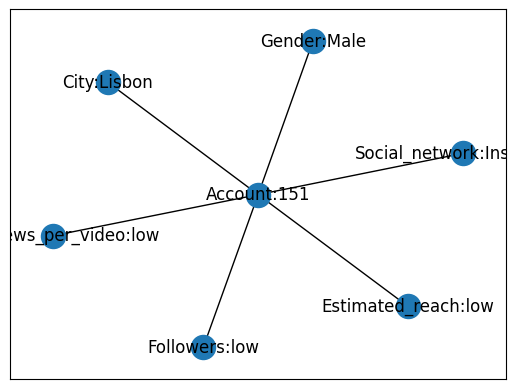

In [237]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

subgraph = nx.ego_graph(G, 'Account:151', radius=1)

# plot the subgraph
pos= None
# nx.draw_networkx_nodes(subgraph,pos,node_color='r', node_size=500)
# nx.draw_networkx_edges(subgraph, pos, edge_color='r')
# nx.draw_networkx_nodes(G, pos, nodelist=list(set(G.nodes()) - set(subgraph.nodes())), node_color='b', node_size=500)
nx.draw_networkx(subgraph)


In [4]:
# Time for run 105298 rows of data
## Node2vec: 
## GGVec: 30Secs(early stopped) 